In [96]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [97]:
pd.set_option('max_colwidth', 800)

TWEETS_PATH= "../data/raw_tweets_text.csv"
SENTIMENT_PATH="../data/t4sa_text_sentiment.tsv"

#load data
tweets_df = pd.read_csv(TWEETS_PATH, encoding='latin-1', header=0)
sentiment_df= pd.read_csv(SENTIMENT_PATH, sep='\t', header=0)

# Basic Information

In [98]:
print(tweets_df.shape)
print(sentiment_df.shape)

(3452663, 2)
(1179957, 4)


In [99]:
print(tweets_df.head())
print(sentiment_df.head())

                   id  \
0  758014713804587008   
1  758014717990428672   
2  758014646716665857   
3  758014655071526912   
4  758014642526429184   

                                                                                                                                             text  
0  RT @polarcomic: And surprise! the #RegularShow #38 has a short story written and illustrated (and even lettered) by me. https://t.co/kCctJpâ¦  
1                                             RT @SweetBabyBellB: My unproblematic fav who knows Bellarke is fucking real https://t.co/A9RK5b0Hfm  
2                                                                    RT @WhyLarryIsReal: I mean we know harry isn't human https://t.co/fW2TEwSHEq  
3          RT @Eastbay: She's ready, resilient, and on our latest cover. Snag a copy to find out more about @crysdunn_19. https://t.co/j4JwiEgCmd  
4                             RT @SheeeRatchet: find someone who loves you as much as Pikachu loves his bottl

In [100]:
print(tweets_df.describe())
print(sentiment_df.describe())

                 id
count  3.452663e+06
mean   7.865426e+17
std    1.381574e+16
min    7.580146e+17
25%    7.695707e+17
50%    7.862700e+17
75%    7.993751e+17
max    8.046194e+17
               TWID           NEG           NEU           POS
count  1.179957e+06  1.179957e+06  1.179957e+06  1.179957e+06
mean   7.860716e+17  1.214643e-01  5.272504e-01  3.512854e-01
std    1.386547e+16  2.489799e-01  3.953345e-01  3.879292e-01
min    7.680969e+17  2.930239e-14  2.250815e-03  2.441870e-14
25%    7.692905e+17  1.118029e-02  8.237851e-02  7.404817e-02
50%    7.839379e+17  1.924086e-02  8.548171e-01  1.057651e-01
75%    7.996407e+17  3.546559e-02  8.904971e-01  8.860867e-01
max    8.046194e+17  9.939882e-01  1.000000e+00  9.965788e-01


# Cleaning the Data

In [101]:


print("Duplicate amounts in tweets_df:")
print(tweets_df['id'].duplicated().sum()) # There are no duplicates in either dataset

print("Duplicate amounts in sentiment_df:")
print(sentiment_df.duplicated().sum())

# Check for missing values in tweets_df
print("Missing values in tweets_df:")
print(tweets_df.isna().sum())

# Check for missing values in sentiment_df
print("\nMissing values in sentiment_df:")
print(sentiment_df.isna().sum())



Duplicate amounts in tweets_df:
0
Duplicate amounts in sentiment_df:
0
Missing values in tweets_df:
id      0
text    0
dtype: int64

Missing values in sentiment_df:
TWID    0
NEG     0
NEU     0
POS     0
dtype: int64


In [102]:
merged_df = pd.merge(tweets_df, sentiment_df, left_on='id', right_on='TWID')
merged_df = merged_df.drop(columns=['TWID']) # since its alr in id

main_df = merged_df.copy()

In [103]:
# Useful functions to help extract data from the columns

def extract_username_from_text(text):     # Extracts the username from retweets (e.g., "RT @user:").
    match = re.search(r'^RT @([^\s:]+):', text)
    return match.group(1) if match else None
     
def extract_links_from_text(text): # Extracts URLs from tweet text.
    urls = re.findall(r'https?://\S+', text)
    if not urls:
        return None
    return urls[0] if len(urls) == 1 else urls
           
def extract_hashtags_from_text(text): # Extract hashtags from the tweet text
    hashtags = re.findall(r'#\w+', text)
    if not hashtags:
        return None
    return hashtags[0] if len(hashtags) == 1 else hashtags
    
def extract_mentions_from_text(text): # Extract mentions from the tweet text
    cleaned_text = re.sub(r'^RT @[^\s:]+: ', '', text) # Remove the initial retweet username (e.g., "RT @user:")
    mentions = re.findall(r'@\w+', cleaned_text)
    if not mentions:
        return None
    return mentions[0] if len(mentions) == 1 else mentions



def clean_tweet_text(text: str):
    """
    Cleans the tweet text for EDA by removing noise such as:
    - Retweet prefixes (RT @user:)
    - URLs
    - HTML entities (e.g., &amp;)
    - Extra whitespace
    - Remove mentions
    """
    # Remove retweet header
    text = re.sub(r'^RT @[^\s:]+: ', '', text)
    
    # Remove URLs
    # Remove URLs including malformed/truncated ones (e.g., "httpsâ")
    text = re.sub(r'https?\S+|www\.\S+', '', text)
    
    # Remove HTML entities like &amp;
    text = re.sub(r'&\w+;', '', text)
    
    # Remove extra spaces and trim
    text = re.sub(r'\s+', ' ', text).strip()

    #remove metions
    text = re.sub(r'@\w+', '', text)

    
    return text

In [104]:
# Start adding extra columns that might help us with visualizations
main_df['is_retweet'] = main_df['text'].str.startswith('RT ')
main_df['username'] = main_df['text'].apply(extract_username_from_text)
main_df['urls'] = main_df['text'].apply(extract_links_from_text)
main_df['cleaned_text'] = main_df['text'].apply(clean_tweet_text)
main_df['hashtags'] = main_df['text'].apply(extract_hashtags_from_text)
main_df['mentions'] = main_df['text'].apply(extract_mentions_from_text)

main_df
# filter to rows where cleaned_text contains 'https'




,id,text,NEG,NEU,POS,is_retweet,username,urls,cleaned_text,hashtags,mentions
0,768097627686604801,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0,0.008090,0.042331,0.949579,False,None,"[https://t.co/antImqAo4Y, https://t.co/ejnA78Sks0]",Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday,None,None
1,768097631864102912,RT @2pmthailfans: [Pic] Nichkhun from krjeong86's IG https://t.co/5gcAcu9by7,0.014644,0.926557,0.058800,True,2pmthailfans,https://t.co/5gcAcu9by7,[Pic] Nichkhun from krjeong86's IG,None,None
2,768097640278089729,RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1oâ¦,0.004939,0.029469,0.965591,True,MianUsmanJaved,https://t.co/1oâ¦,Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies,"[#No1TestTeam, #JI_PakZindabadRallies]",None
3,768097627695042560,"RT @PEPalerts: This September, @YESmag is taking you to Maine Mendozaâs surprise thanksgiving party she threw for her fans! https://t.co/oXâ¦",0.006389,0.018663,0.974948,True,PEPalerts,https://t.co/oXâ¦,"This September, is taking you to Maine Mendozaâs surprise thanksgiving party she threw for her fans!",None,@YESmag
4,768096868504969216,#Incredible #India #Atulya #Bharat - Land of Seekers #BeProud ð ð®ð³ :|: Plz RT https://t.co/vpghReZWsa,0.049398,0.861395,0.089207,False,None,https://t.co/vpghReZWsa,#Incredible #India #Atulya #Bharat - Land of Seekers #BeProud ð ð®ð³ :|: Plz RT,"[#Incredible, #India, #Atulya, #Bharat, #BeProud]",None
...,...,...,...,...,...,...,...,...,...,...,...
1179952,804618351179874304,@LizHudston @KymWyllie @Evasmiless @meanBok @linddyloo66 @Minna1971 morning girls have a wonderful #Friday https://t.co/unkV2p7JYF,0.006605,0.024448,0.968946,False,None,https://t.co/unkV2p7JYF,morning girls have a wonderful #Friday,#Friday,"[@LizHudston, @KymWyllie, @Evasmiless, @meanBok, @linddyloo66, @Minna1971]"
1179953,804618548312031232,#RT #Follow Colin Kaepernick debated merits of Castro'sâ¦ - The Mercury News https://t.co/XtrtILIfBl https://t.co/lvUwwdsD4b,0.028834,0.857713,0.113453,False,None,"[https://t.co/XtrtILIfBl, https://t.co/lvUwwdsD4b]",#RT #Follow Colin Kaepernick debated merits of Castro'sâ¦ - The Mercury News,"[#RT, #Follow]",None
1179954,804618716084391936,I am now live on webcam find me here &gt;&gt; https://t.co/yg0pJss4MK download our app &gt;&gt; here https://t.co/QMXtTx4Gcr https://t.co/qxJFN7ZO5U,0.018679,0.927865,0.053456,False,None,"[https://t.co/yg0pJss4MK, https://t.co/QMXtTx4Gcr, https://t.co/qxJFN7ZO5U]",I am now live on webcam find me here download our app here,None,None
1179955,804618934158757889,Pearl Roadshow 4-piece Complete Drum Set with Cymb https://t.co/gQ2TdFKnma https://t.co/PL2FXvWRo9,0.019658,0.907034,0.073308,False,None,"[https://t.co/gQ2TdFKnma, https://t.co/PL2FXvWRo9]",Pearl Roadshow 4-piece Complete Drum Set with Cymb,None,None


In [105]:
EDA_DF=main_df.copy()

#for easier analysis, create a single sentiment column, loses some info but easier to visualize

we also drop values with low confidence scores.

In [106]:
threshold = 0.9
cols=['NEG', 'NEU', 'POS']
EDA_DF[cols] = EDA_DF[cols].apply(pd.to_numeric, errors='coerce').fillna(0)
EDA_DF['dominant_sentiment'] = EDA_DF[cols].idxmax(axis=1)   # 'NEG'/'NEU'/'POS'
EDA_DF['dominant_score'] = EDA_DF[cols].max(axis=1)
# drop rows with low confidence
EDA_DF = EDA_DF[EDA_DF['dominant_score'] >= threshold].copy()

#adding word and text based features
EDA_DF['word_count'] = EDA_DF['cleaned_text'].apply(lambda x: len(x.split()))
EDA_DF['text_length'] = EDA_DF['cleaned_text'].str.len()
EDA_DF['avg_word_length'] = EDA_DF['cleaned_text'].apply(lambda t: np.mean([len(w) for w in t.split()]) if t.split() else 0)

#drop useless columns
EDA_DF.drop(columns=['text','NEG','NEU','POS', 'is_retweet', 'username', 'urls', 'mentions', 'hashtags'], inplace=True)
EDA_DF

,id,cleaned_text,dominant_sentiment,dominant_score,word_count,text_length,avg_word_length
0,768097627686604801,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday,POS,0.949579,11,66,5.090909
1,768097631864102912,[Pic] Nichkhun from krjeong86's IG,NEU,0.926557,5,34,6.000000
2,768097640278089729,Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies,POS,0.965591,12,103,7.666667
3,768097627695042560,"This September, is taking you to Maine Mendozaâs surprise thanksgiving party she threw for her fans!",POS,0.974948,16,103,5.437500
5,768097661237026816,"Newly painted walls, thanks a million to our custodial painters this summer. Great job ladies!!!#EC_proud",POS,0.956987,15,105,6.066667
...,...,...,...,...,...,...,...
1179951,804618086913437696,#antsmasher I smashed 7 ants in this awesome game!!!hjfjfi,POS,0.956799,9,58,5.555556
1179952,804618351179874304,morning girls have a wonderful #Friday,POS,0.968946,6,44,5.500000
1179954,804618716084391936,I am now live on webcam find me here download our app here,NEU,0.927865,13,58,3.538462
1179955,804618934158757889,Pearl Roadshow 4-piece Complete Drum Set with Cymb,NEU,0.907034,8,50,5.375000


In [107]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
try:
    stop_words = stopwords.words('english')
except LookupError:
    import nltk
    nltk.download('stopwords')
    stop_words = stopwords.words('english')

vectorizer = CountVectorizer(stop_words=stop_words, min_df=40, ngram_range=(1,3)) 
#fit on entire dataset
vectorizer.fit(EDA_DF['cleaned_text'])

#transform each subset
neg_matrix = vectorizer.transform(EDA_DF[EDA_DF['dominant_sentiment'] == 'NEG']['cleaned_text'])
pos_matrix = vectorizer.transform(EDA_DF[EDA_DF['dominant_sentiment'] == 'POS']['cleaned_text'])
neu_matrix = vectorizer.transform(EDA_DF[EDA_DF['dominant_sentiment'] == 'NEU']['cleaned_text'])

vocab = np.array(vectorizer.get_feature_names_out())

#  counts number of tweets containing a word(multiple words in same tweet are not counterd twice)
neg_counts = np.asarray((neg_matrix > 0).sum(axis=0)).ravel()
neu_counts = np.asarray((neu_matrix > 0).sum(axis=0)).ravel()
pos_counts = np.asarray((pos_matrix > 0).sum(axis=0)).ravel()


word_freq = pd.DataFrame({
    'word': vocab,
    'neg_count': neg_counts,
    'neu_count': neu_counts,
    'pos_count': pos_counts
})


word_freq['total_count'] = word_freq[['neg_count', 'neu_count', 'pos_count']].sum(axis=1)

# handle ngrams
max_n = vectorizer.ngram_range[1] 
word_freq['ngram_len'] = word_freq['word'].str.split().apply(len)
word_freq['is_ngram'] = word_freq['ngram_len'] > 1


# supports 
total_docs = len(EDA_DF)
word_freq['support_neg'] = word_freq['neg_count'] / total_docs
word_freq['support_neu'] = word_freq['neu_count'] / total_docs
word_freq['support_pos'] = word_freq['pos_count'] / total_docs

# confidence 
word_freq[['confidence_neg', 'confidence_neu', 'confidence_pos']] = (
    word_freq[['neg_count', 'neu_count', 'pos_count']]
    .div(word_freq['total_count'].replace(0, np.nan), axis=0)
    .fillna(0)
)




In [108]:
print(word_freq.info())
word_freq.sort_values(by=['ngram_len', 'pos_count'], ascending=[False, False]).head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17961 entries, 0 to 17960
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   word            17961 non-null  object 
 1   neg_count       17961 non-null  int64  
 2   neu_count       17961 non-null  int64  
 3   pos_count       17961 non-null  int64  
 4   total_count     17961 non-null  int64  
 5   ngram_len       17961 non-null  int64  
 6   is_ngram        17961 non-null  bool   
 7   support_neg     17961 non-null  float64
 8   support_neu     17961 non-null  float64
 9   support_pos     17961 non-null  float64
 10  confidence_neg  17961 non-null  float64
 11  confidence_neu  17961 non-null  float64
 12  confidence_pos  17961 non-null  float64
dtypes: bool(1), float64(6), int64(5), object(1)
memory usage: 1.7+ MB
None


,word,neg_count,neu_count,pos_count,total_count,ngram_len,is_ngram,support_neg,support_neu,support_pos,confidence_neg,confidence_neu,confidence_pos
5984,found transponder snail,0,4145,11365,15510,3,True,0.0,0.008216,0.022526,0.0,0.267247,0.732753
6589,giants sea monsters,0,0,9710,9710,3,True,0.0,0.000000,0.019246,0.0,0.000000,1.000000
10521,monsters amazing encounters,0,0,9710,9710,3,True,0.0,0.000000,0.019246,0.0,0.000000,1.000000
13867,sea monsters amazing,0,0,9710,9710,3,True,0.0,0.000000,0.019246,0.0,0.000000,1.000000
14499,snail giants sea,0,0,9710,9710,3,True,0.0,0.000000,0.019246,0.0,0.000000,1.000000


Visualizing


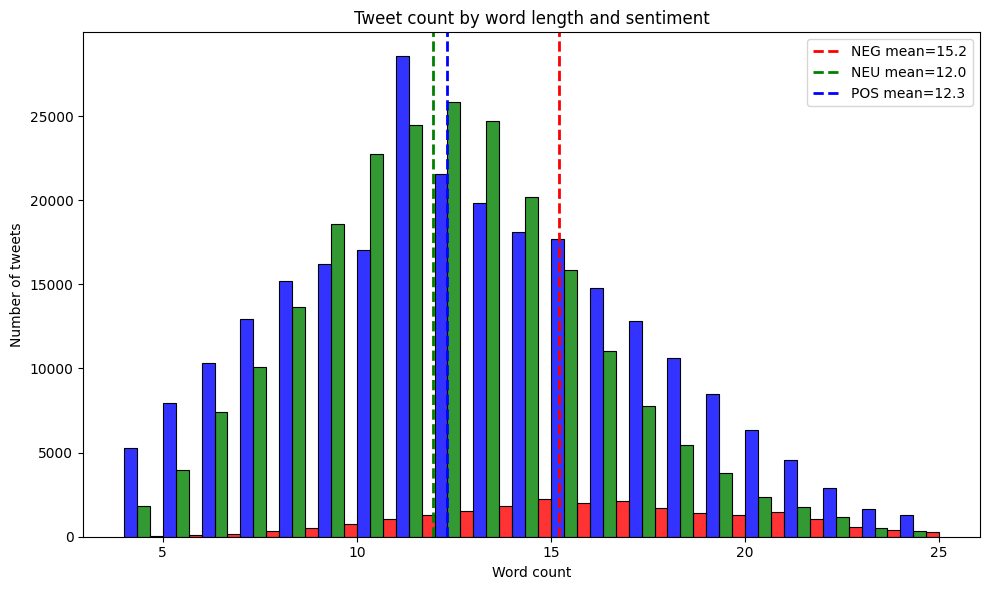

In [109]:
from matplotlib.lines import Line2D

# Seaborn histogram of tweet word counts (capped at 100) with hue by sentiment
capped = EDA_DF['word_count']
plt.figure(figsize=(10,6))
palette = {'NEG': 'red', 'NEU': 'green', 'POS': 'blue'}

sns.histplot(
    data=EDA_DF.assign(word_count_capped=capped),
    x='word_count_capped',
    bins=range(4,26),
    hue='dominant_sentiment',
    multiple='dodge',
    element='bars',
    stat='count',
    alpha=0.8,
    palette=palette
)

group_means = EDA_DF.assign(word_count_capped=capped).groupby('dominant_sentiment')['word_count_capped'].mean()
for sent, mean_val in group_means.items():
    plt.axvline(mean_val, color=palette.get(sent, 'k'), linestyle='--', linewidth=2, label=f"{sent} mean={mean_val:.1f}")

plt.legend(loc='best')
plt.xlabel('Word count')
plt.ylabel('Number of tweets')
plt.title('Tweet count by word length and sentiment')
plt.tight_layout()
plt.show()


word count visualizations

In [115]:
# analyze / visualize word_freq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

wf = word_freq.copy()
wf['log_total'] = np.log1p(wf['total_count'])
wf['dominant'] = wf[['neg_count','neu_count','pos_count']].idxmax(axis=1)

palette = {'neg_count':'red','neu_count':'green','pos_count':'blue'}
wf['support'] = wf['total_count'] / len(EDA_DF)   # or use support_pos etc.
wf['support_log10'] = np.log10(wf['support'] + 1e-12)





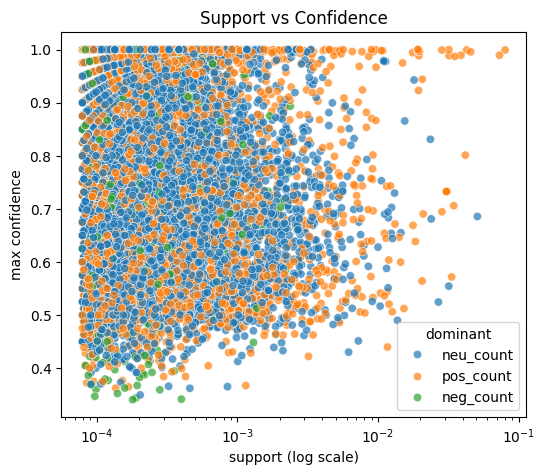

In [116]:
#support vs confidence scatter 
wf['confidence_max'] = wf[['confidence_neg','confidence_neu','confidence_pos']].max(axis=1)
plt.figure(figsize=(6,5))
sns.scatterplot(data=wf, x='support', y='confidence_max', hue='dominant', alpha=0.7)
plt.xscale('log'); plt.xlabel('support (log scale)'); plt.ylabel('max confidence'); plt.title('Support vs Confidence'); plt.show()



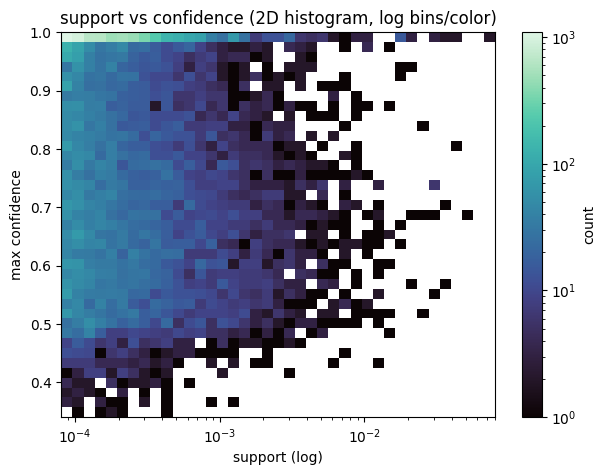

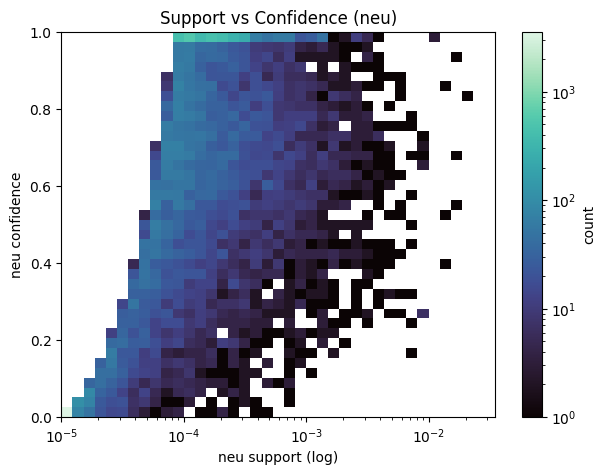

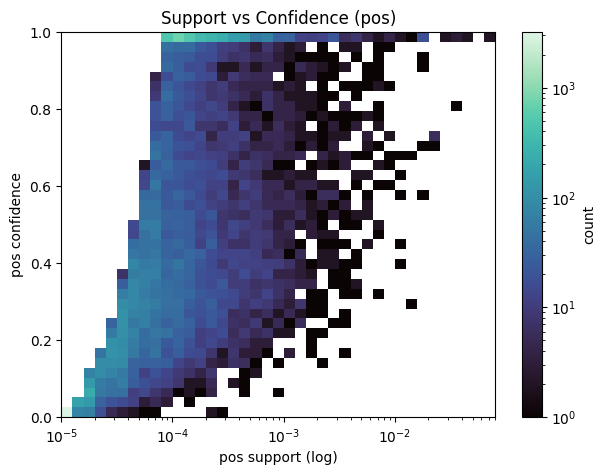

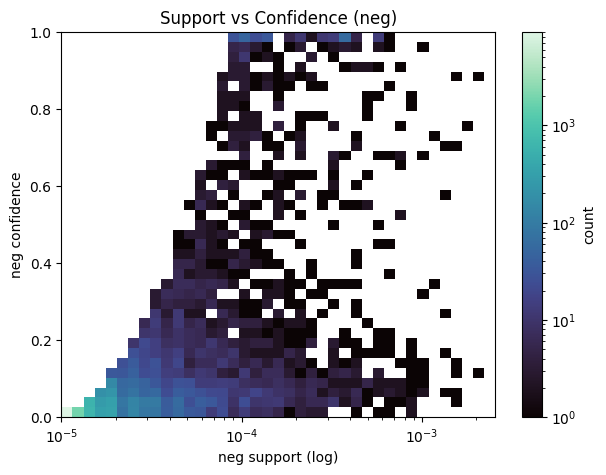

/tmp/ipykernel_18549/779872682.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = wf.groupby(pd.cut(wf['support_log10'], bins=bins)).agg(


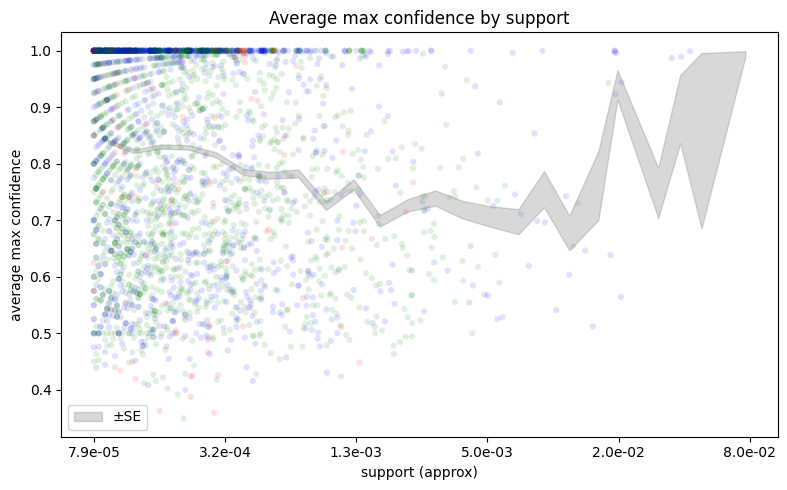

In [117]:
import matplotlib.colors as colors

# 2D histograms
eps = 1e-6
x = (wf['support'] + eps).values
y = wf['confidence_max'].values
xbins = np.logspace(np.log10(x[x>0].min()), np.log10(x.max()), 40)
ybins = np.linspace(y.min(), y.max(), 40)
H, xe, ye = np.histogram2d(x, y, bins=[xbins, ybins])
plt.figure(figsize=(7,5))
plt.pcolormesh(xe, ye, H.T, norm=colors.LogNorm(), cmap='mako')
plt.xscale('log')
plt.colorbar(label='count')
plt.xlabel('support (log)')
plt.ylabel('max confidence')
plt.title('support vs confidence (2D histogram, log bins/color)')
plt.show()

for sent, s_col, c_col in [('neu','support_neu','confidence_neu'),
                          ('pos','support_pos','confidence_pos'),
                          ('neg','support_neg','confidence_neg')]:
    eps = 1e-5
    x = (wf[s_col] + eps).values
    y = wf[c_col].values
    x_pos = x[x>0]
    if x_pos.size == 0:
        continue
    xbins = np.logspace(np.log10(x_pos.min()), np.log10(x.max()), 40)
    ybins = np.linspace(y.min(), y.max(), 40)
    H, xe, ye = np.histogram2d(x, y, bins=[xbins, ybins])
    plt.figure(figsize=(7,5))
    # safe LogNorm vmin (must be >0)
    vmin = H[H>0].min() if H[H>0].size else 1.0
    pcm = plt.pcolormesh(xe, ye, H.T, norm=colors.LogNorm(vmin=vmin, vmax=H.max()), cmap='mako')
    plt.xscale('log')
    plt.colorbar(pcm, label='count')
    plt.xlabel(f'{sent} support (log)')
    plt.ylabel(f'{sent} confidence')
    plt.title(f'Support vs Confidence ({sent})')
    plt.show()


# average max-confidence by support 
bins = np.linspace(wf['support_log10'].min(), wf['support_log10'].max(), 25)
grouped = wf.groupby(pd.cut(wf['support_log10'], bins=bins)).agg(
    support_log10_mean=('support_log10','mean'),
    mean_conf=('confidence_max','mean'),
    se_conf=('confidence_max', lambda x: x.std()/np.sqrt(len(x))),
    count=('word','count')
).reset_index().dropna()

plt.figure(figsize=(8,5))
# sample n points
sample = wf.sample(n=min(3000, len(wf)), random_state=1)
sns.scatterplot(data=sample, x='support_log10', y='confidence_max', hue='dominant',
                palette=palette, alpha=0.12, s=20, linewidth=0, legend=False)

# plot mean
plt.fill_between(grouped['support_log10_mean'],
                 grouped['mean_conf'] - grouped['se_conf'],
                 grouped['mean_conf'] + grouped['se_conf'],
                 color='gray', alpha=0.3, label='±SE')


ticks = np.linspace(wf['support_log10'].min(), wf['support_log10'].max(), 6)
plt.xticks(ticks, [f"{10**t:.1e}" for t in ticks])
plt.xlabel('support (approx)')
plt.ylabel('average max confidence')
plt.title('Average max confidence by support')
plt.legend()
plt.tight_layout()
plt.show()





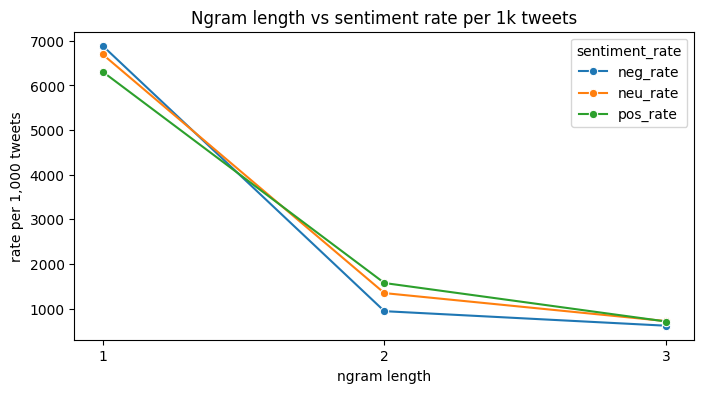

In [118]:
#  ngram length vs sentiment counts
ngram_sentiment = wf.groupby('ngram_len')[['neg_count','neu_count','pos_count']].sum().reset_index()

sent_totals = EDA_DF['dominant_sentiment'].value_counts()
tot_neg = sent_totals.get('NEG', 0)
tot_neu = sent_totals.get('NEU', 0)
tot_pos = sent_totals.get('POS', 0)

# per capita rates rather than raw counts, neg too low
scale = 1000
ngram_sentiment['neg_rate'] = ngram_sentiment['neg_count'] / tot_neg * scale
ngram_sentiment['neu_rate'] = ngram_sentiment['neu_count'] / tot_neu * scale
ngram_sentiment['pos_rate'] = ngram_sentiment['pos_count'] / tot_pos * scale

# melt for plotting
ngram_rates_melted = ngram_sentiment.melt(id_vars='ngram_len', value_vars=['neg_rate','neu_rate','pos_rate'],
                                          var_name='sentiment_rate', value_name='rate_per_1k')

# Plot normalized rates per 1k docs
plt.figure(figsize=(8,4))
sns.lineplot(data=ngram_rates_melted, x='ngram_len', y='rate_per_1k', hue='sentiment_rate', marker='o')
plt.title('Ngram length vs sentiment rate per 1k tweets')
plt.xlabel('ngram length'); plt.ylabel('rate per 1,000 tweets'); plt.xticks(sorted(wf['ngram_len'].unique())); 
plt.show()